In [27]:
import pandas as pd
import pathlib
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [28]:
work_path = pathlib.Path.cwd()
data_path = Path(work_path, 'data', 'Telco-Customer-Churn.csv')
data = pd.read_csv(data_path)


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# EDA

In [30]:
data['Churn'] = np.where(data['Churn'] == 'Yes', 1, 0)
data['Partner'] = np.where(data['Partner'] == 'Yes', 1, 0)
data['Dependents'] = np.where(data['Dependents'] == 'Yes', 1, 0)
data['PhoneService'] = np.where(data['PhoneService'] == 'Yes', 1, 0)
data['PaperlessBilling'] = np.where(data['PaperlessBilling'] == 'Yes', 1, 0)
data['gender'] = np.where(data['gender'] == 'Male', 1, 0)

In [31]:
two_categorical_column = []
other_categorical_column = []
for column in data.columns[1:-3].drop('tenure'):
    if len(data[column].unique()) == 2:
        two_categorical_column.append(column)
    else:
        other_categorical_column.append(column)
    print('Количество уникальных значений {0} = {1}'.format(column, data[column].unique()))

Количество уникальных значений gender = [0 1]
Количество уникальных значений SeniorCitizen = [0 1]
Количество уникальных значений Partner = [1 0]
Количество уникальных значений Dependents = [0 1]
Количество уникальных значений PhoneService = [0 1]
Количество уникальных значений MultipleLines = ['No phone service' 'No' 'Yes']
Количество уникальных значений InternetService = ['DSL' 'Fiber optic' 'No']
Количество уникальных значений OnlineSecurity = ['No' 'Yes' 'No internet service']
Количество уникальных значений OnlineBackup = ['Yes' 'No' 'No internet service']
Количество уникальных значений DeviceProtection = ['No' 'Yes' 'No internet service']
Количество уникальных значений TechSupport = ['No' 'Yes' 'No internet service']
Количество уникальных значений StreamingTV = ['No' 'Yes' 'No internet service']
Количество уникальных значений StreamingMovies = ['No' 'Yes' 'No internet service']
Количество уникальных значений Contract = ['Month-to-month' 'One year' 'Two year']
Количество уникальных

In [32]:
ohe = OneHotEncoder()
ohe_data = pd.DataFrame(ohe.fit_transform(data[other_categorical_column]).toarray(), columns=ohe.get_feature_names_out())

In [33]:
data.drop(other_categorical_column + ['customerID'], axis=1, inplace=True)
data = pd.concat([data, ohe_data], axis=1)

In [34]:
data.loc[data.TotalCharges == ' ', 'TotalCharges'] = np.nan
data.dropna(axis=0, inplace=True)
data['TotalCharges'] = data['TotalCharges'].astype(float)
#data['TotalCharges'].fillna((data['TotalCharges'].mode()), inplace=True)

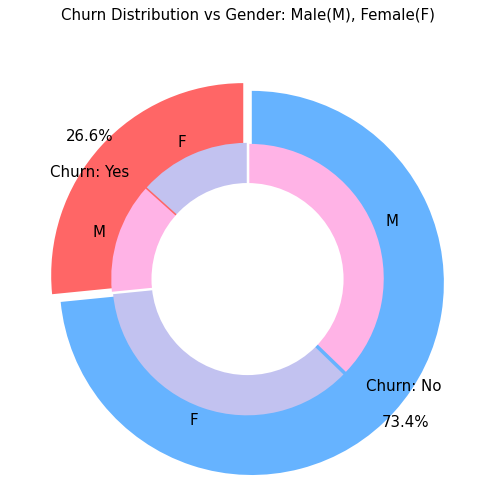

In [35]:
plt.figure(figsize=(7, 7))
labels =["Churn: Yes","Churn: No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939, 930, 2544, 2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3, 0.3) 
explode_gender = (0.1, 0.1, 0.1, 0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels, autopct='%1.1f%%', pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender, labels=labels_gender, colors=colors_gender, startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )

#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution vs Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

# Машинное обучение

In [36]:
# Признаки
X = data.drop('Churn', axis=1)
# Таргет
y = data['Churn']

In [37]:
# Разделение данных на обучающий и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=42)

# Случайный лес

In [38]:
# Количество деревьев
n_estimators = [int(x) for x in np.linspace(100, 1200, 10)]
# Число признаков для выбора расщепления
max_features = ['auto', 'sqrt']
# Максимальная глубина деревьев
max_depth = [int(x) for x in np.linspace(3, 20, 6)]
# Минимальное число объектов, при котором выполняется расщепление
min_samples_split = [2, 5, 10, 15, 100]
# Ограничение на число объектов в листьях
min_samples_leaf = [1, 2, 5, 10]
# Использование для построения деревьев подвыборки с возвращением
bootstrap = [True, False]
# Сетка гиперпараметров 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }

print(random_grid)

{'n_estimators': [100, 222, 344, 466, 588, 711, 833, 955, 1077, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 6, 9, 13, 16, 20], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False]}


In [39]:
# Создание экземпляра класса RandomForestClassifier
forest = RandomForestClassifier()
# Рандомизированный поиск гиперпараметров
random_grid = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs =-1)
# Обучение модели
random_grid.fit(X_train,y_train)
print(f'Лучшие параметры модели: {random_grid.best_params_}')
print(f'Лучший результат: {random_grid.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры модели: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 6, 'bootstrap': False}
Лучший результат: 0.8037567560275907


In [40]:
# Создание экземпляра модели на основе оптимизированных гиперпараметров модели
forest = RandomForestClassifier(n_estimators=1200, min_samples_split=5, 
random_state=42, min_samples_leaf=5, max_features='auto', bootstrap='False', max_depth=15)
# Обучение модели
forest.fit(X_train, y_train)
# Предсказание модели на тестовых данных
predict_forest = forest.predict(X_test)

[['True Neg\n1178' 'False Pos\n122']
 ['False Neg\n237' 'True Pos\n221']]


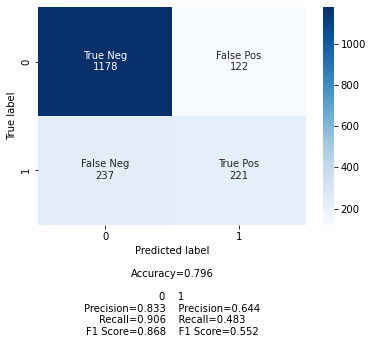

In [100]:
cf_matrix_forest = confusion_matrix(y_test, predict_forest)
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
# Функция для визуализаций матрицы ошибок 
def make_confusion_matrix(cf,
                          group_names=None,
                          count=True,
                          cbar=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
   
    # Код для создания текста внутри квадрата
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    
    
    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels,group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    print(box_labels)
    # Код для генераций суммарной статистики и текса
    if sum_stats:
        #Вычисляем accuracy
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # Если бинарная матрица ошибок
        if len(cf)==2:
            # Метрики для бинарной матрицы ошибок
            precision_1 = cf[1,1] / sum(cf[:,1])
            recall_1    = cf[1,1] / sum(cf[1,:])
            f1_score_1  = 2*precision_1*recall_1 / (precision_1 + recall_1)

            precision_0 = cf[0,0] / sum(cf[:,0])
            recall_0    = cf[0,0] / sum(cf[0,:])
            f1_score_0  = 2*precision_0*recall_0 / (precision_0 + recall_0)

            stats_text = "\n\nAccuracy={:0.3f}\n\n0    1\nPrecision={:0.3f}    Precision={:0.3f}\nRecall={:0.3f}    Recall={:0.3f}\nF1 Score={:0.3f}    F1 Score={:0.3f}".format(
                accuracy,precision_0, precision_1,recall_0, recall_1,f1_score_0, f1_score_1)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # Параметры рисунка
    if figsize==None:
        # Значение по умолчанию
        figsize = plt.rcParams.get('figure.figsize')

    

    # Визуализация матрицы ошибок
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

make_confusion_matrix(cf_matrix_forest, group_names)


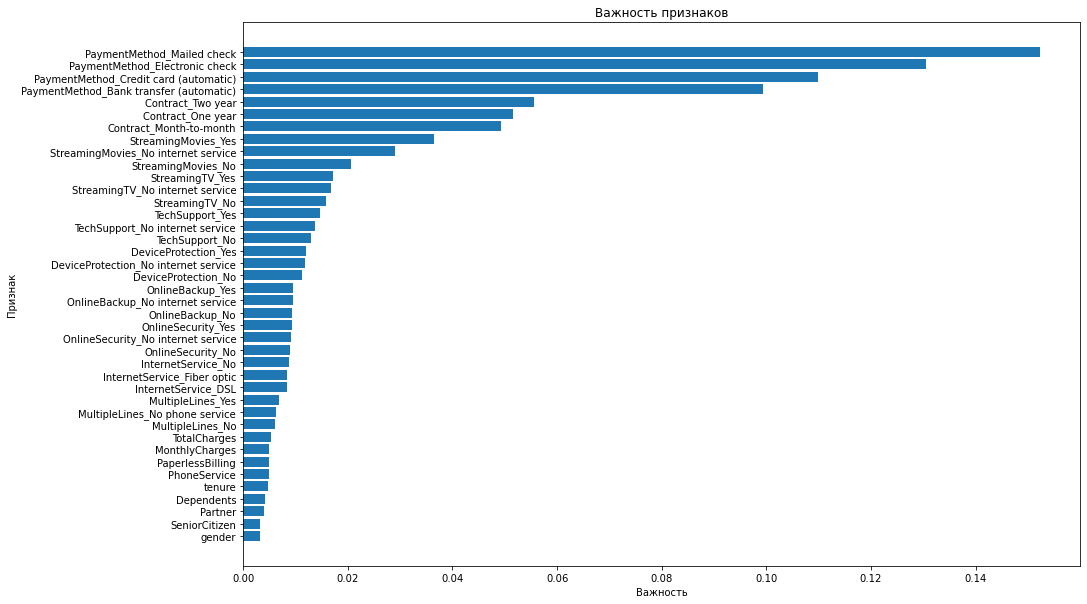

In [85]:
# Создаем датафрейм на основе важности признаков
importance = pd.DataFrame({'features': X.columns, 'feature_importances_':forest.feature_importances_,})
# Сортируем по возрастанию
importance = importance.sort_values(by='feature_importances_')

# Количество признаков
n_features = X_train.shape[1]

# Визуализируем график важности признаков
plt.figure(figsize=(15, 10))
plt.barh(np.arange(n_features), importance.feature_importances_)
plt.yticks(np.arange(n_features), X.columns)
plt.ylabel("Признак")
plt.xlabel('Важность')
plt.title('Важность признаков')
plt.show()

# KNN

In [43]:
# Список ошибки предказания
error_rate=list()
# Выявляем оптимальное число соседей
for i in range(1, 40):
    # Создаем экземпляр класса
    knn=KNeighborsClassifier(n_neighbors=i)
    # Обучаем модель на тренировочных данных
    knn.fit(X_train,y_train)
    # Предсказание на тестовых данных
    prediction_i=knn.predict(X_test)
    error_rate.append(np.sum(prediction_i != y_test))

Text(0, 0.5, 'Количество ошибок')

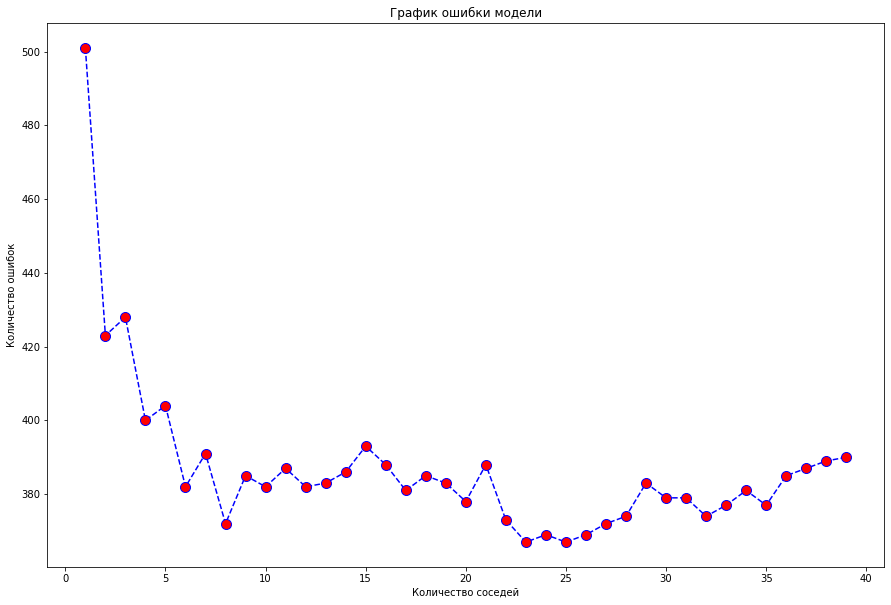

In [44]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 40), error_rate, color="blue", linestyle="--", marker="o", markerfacecolor="red", markersize=10)
plt.title("График ошибки модели")
plt.xlabel("Количество соседей")
plt.ylabel("Количество ошибок")

In [86]:
knn=KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)
predict_knn=knn.predict(X_test)

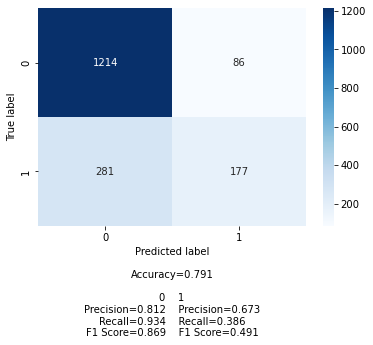

In [91]:
cf_knn = confusion_matrix(y_test, predict_knn)
make_confusion_matrix(cf_knn)

# Дерево решений

In [48]:

dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [49]:
print(tree.export_text(dtree))

|--- feature_33 <= 0.50
|   |--- feature_7 <= 93.67
|   |   |--- feature_35 <= 0.50
|   |   |   |--- feature_32 <= 0.50
|   |   |   |   |--- feature_38 <= 0.50
|   |   |   |   |   |--- feature_8 <= 37.08
|   |   |   |   |   |   |--- feature_8 <= 35.35
|   |   |   |   |   |   |   |--- feature_7 <= 19.47
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_7 >  19.47
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_8 >  35.35
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_8 >  37.08
|   |   |   |   |   |   |--- feature_7 <= 60.27
|   |   |   |   |   |   |   |--- feature_15 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_8 <= 231.75
|   |   |   |   |   |   |   |   |   |--- feature_8 <= 229.18
|   |   |   |   |   |   |   |   |   |   |--- feature_6 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- feature_6 >  0.50
|   |   |   |   

In [50]:
predictions = dtree.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[1038  262]
 [ 225  233]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1300
           1       0.47      0.51      0.49       458

    accuracy                           0.72      1758
   macro avg       0.65      0.65      0.65      1758
weighted avg       0.73      0.72      0.73      1758

0.7229806598407281


# Метод опорных векторов

In [51]:
param_grid={"C":[1,5,10],"gamma":[1, 0.01, 0.001]} 
#here we select values for grid search to try
grid=GridSearchCV(SVC(),param_grid,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .......................................C=1, gamma=1; total time=   3.7s
[CV] END .......................................C=1, gamma=1; total time=   3.5s
[CV] END .......................................C=1, gamma=1; total time=   3.3s
[CV] END .......................................C=1, gamma=1; total time=   3.4s
[CV] END .......................................C=1, gamma=1; total time=   2.8s
[CV] END ....................................C=1, gamma=0.01; total time=   2.8s
[CV] END ....................................C=1, gamma=0.01; total time=   3.0s
[CV] END ....................................C=1, gamma=0.01; total time=   3.3s
[CV] END ....................................C=1, gamma=0.01; total time=   3.8s
[CV] END ....................................C=1, gamma=0.01; total time=   2.8s
[CV] END ...................................C=1, gamma=0.001; total time=   1.8s
[CV] END ...................................C=1, 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 5, 10], 'gamma': [1, 0.01, 0.001]},
             verbose=2)

In [52]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.001}
SVC(C=1, gamma=0.001)


In [53]:
grid_predictions=grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test, grid_predictions))
print(accuracy_score(y_test, grid_predictions))

[[1188  112]
 [ 268  190]]
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1300
           1       0.63      0.41      0.50       458

    accuracy                           0.78      1758
   macro avg       0.72      0.66      0.68      1758
weighted avg       0.77      0.78      0.77      1758

0.7838452787258248


# Логистическая регрессия

In [54]:
Lr = LogisticRegression(C=1)
Lr.fit(X_train, y_train)

LogisticRegression(C=1)

In [55]:
predict = Lr.predict(X_test)

In [56]:
confusion_matrix(predict, y_test)

array([[1165,  226],
       [ 135,  232]], dtype=int64)